In [1]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
from pennylane.optimize import NesterovMomentumOptimizer , GradientDescentOptimizer, AdamOptimizer
#FILE NAMING: VCDR_v7_MD_2Q_ST2_N02_B6L3_BS32_LR02
#             VCDR = Variational Classifier with Data Re-upload
#             MD = Michael's Dataset
#             2Q = 2Qubits
#             ST2 = Surface type 2
#             N02 = noise = 0.2/d
#             B6L3 = 6 Blocks, 2 layers
#             BS32 = Batch size 32
#             LR02 = Learning Rate 0.2
#             optimizer

#entangler = qml.CZ
entangler = qml.CNOT
blocks=3
layers=2
batch_size = 512
n_epochs = 15
test_size=0.2 #(train/test split)
learning_rate = 0.2
#opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = NesterovMomentumOptimizer(learning_rate)
opt = GradientDescentOptimizer(stepsize=learning_rate)
randomseed=1 # Change random seed in weight
scalinga=0 #Normalizing dataset from
scalingb=2* np.pi #Normalizing dataset to

X= pd.read_pickle("X_ST2_N00")
y= pd.read_pickle("y_ST2_N00")

#Simulations
# surface type 0,1,2
# noise= 0.0 , 0.4 , 0.6 , 0.8 , 1.0 , 1.2 
# blocks 3-6-9-12
# layers 1-2-3-5
# optimizer
# batch_size: 32-40-64
# epochs = 25

# use same datasets, so save them 
#A For a surface type=0,1,2 , noise=0 and blocks=1 : Find best layers , optimizers , epochs , batchsize
#B For a surface type=0,1,2 , noise=0 and blocks=3,6,9,12 : Find best layers , optimizers , epochs , batchsize


# Things to try in extreme regimes (zero and max noise) and benchmark with best results:
#1. best simulations benchmark with CZ gates instead of CNOT -> 
#(passing the imprimitive=qml.CZ keyword argument to StronglyEntanglingLayers)

#2. omit the entanglers for the last layer.

#3. cost function studied in the paper (that is also showcased in the Data-reuploading classifier demonstration)
#was related to the fidelity of the final state of the circuit.

#4. Noisy channels https://pennylane.readthedocs.io/en/stable/introduction/operations.html#intro-ref-ops-channels

#5. Use measurement in both qubits and then softmax outcome

#5. Use probability measurement https://pennylane.readthedocs.io/en/stable/introduction/measurements.html

#6. add hadamard gates qml.Hadamard(wires=wires[0])

#7. Try different rotations RX RY in the angle embedding

#In the basic variational classifier 
#1. We measure the outcome of the 1 qubit. Does it make sense to build a procedure that measures 2 qubits? 
#2. How about probability measurement instead of expectation value?
#3. Does it make sense to add Hadamard gates before?
#4. Are there any differences using CNOT and CZ in the strongly entangling layers?
from itertools import chain
%matplotlib inline
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
from pennylane.optimize import GradientDescentOptimizer
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_file, output_notebook, reset_output, ColumnDataSource
import matplotlib.pyplot as plt
from itertools import chain

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
from pennylane.optimize import GradientDescentOptimizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
y = y.astype(np.int64)
y = y.iloc[:, 0]
X = X.to_numpy()
y = y.to_numpy()

In [3]:
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler

#Xnorm = minmax_scale(X, feature_range=(0, np.pi))
#X_train_val, X_test, y_train_val, y_test = train_test_split(Xnorm, y, test_size=0.5)

#y = y.iloc[:, :]
#y = y[0].apply(lambda x: 1 if x <= 0 else -1)
#y = y.to_numpy()
Xnorm = minmax_scale(X, feature_range=(scalinga, scalingb))

#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=test_size, random_state=1)
 

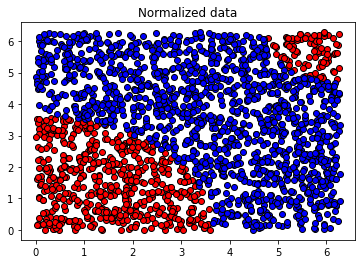

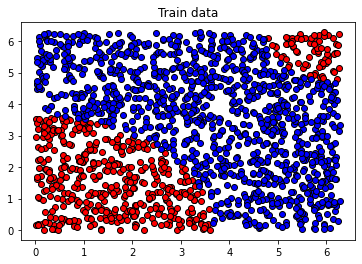

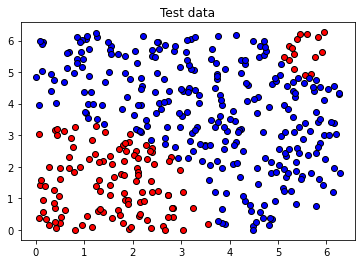

In [4]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(Xnorm[:, 0][y == -1], Xnorm[:, 1][y == -1], c="r", marker="o", edgecolors="k")
plt.scatter(Xnorm[:, 0][y == 1], Xnorm[:, 1][y == 1], c="b", marker="o", edgecolors="k")
plt.title("Normalized data")
plt.show()


plt.figure()
plt.scatter(X_train[:, 0][y_train == -1], X_train[:, 1][y_train == -1], c="r", marker="o", edgecolors="k")
plt.scatter(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], c="b", marker="o", edgecolors="k")
plt.title("Train data")
plt.show()


plt.figure()
plt.scatter(X_test[:, 0][y_test == -1], X_test[:, 1][y_test == -1], c="r", marker="o", edgecolors="k")
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], c="b", marker="o", edgecolors="k")
plt.title("Test data")
plt.show()

<Figure size 432x288 with 0 Axes>

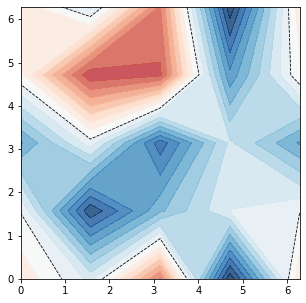

It 1 out of 45 loss:  1.5602888812119289  : Acc train:  0.37  : Acc test :  0.402  : Auc :  0.35


<Figure size 432x288 with 0 Axes>

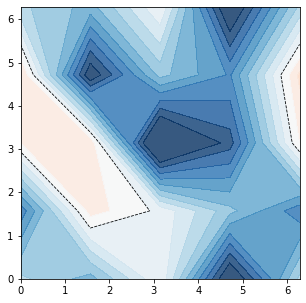

It 11 out of 45 loss:  0.6071004829562244  : Acc train:  0.81  : Acc test :  0.788  : Auc :  0.721


<Figure size 432x288 with 0 Axes>

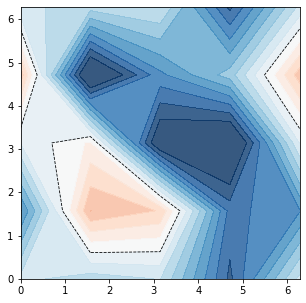

It 21 out of 45 loss:  0.5111442616665575  : Acc train:  0.85  : Acc test :  0.822  : Auc :  0.776


<Figure size 432x288 with 0 Axes>

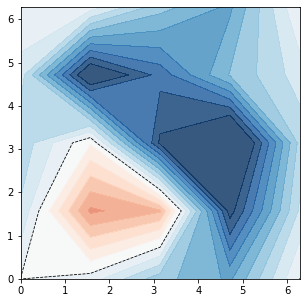

It 31 out of 45 loss:  0.39141075339840686  : Acc train:  0.91  : Acc test :  0.912  : Auc :  0.88


<Figure size 432x288 with 0 Axes>

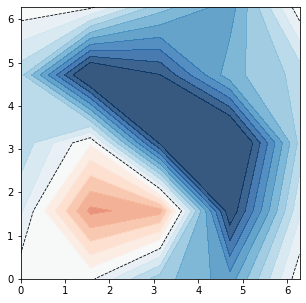

It 41 out of 45 loss:  0.30351164097867916  : Acc train:  0.93  : Acc test :  0.935  : Auc :  0.914


In [5]:
from sklearn.metrics import roc_auc_score
# select number of qubits
#n_qubits = X.shape[1] # number of qubits is equal to the number of features = 2
n_qubits =2 

# quantum device handle
dev = qml.device("default.qubit", wires=n_qubits)
# quantum circuit
#
#

@qml.qnode(dev)
def circuit(weights, x=None):
#    qml.Hadamard(wires=0)
#    qml.Hadamard(wires=1)
    for i in range(blocks):
        AngleEmbedding(x, wires = range(n_qubits))
        StronglyEntanglingLayers(weights[i], wires = range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# variational quantum classifier
def variational_classifier(theta, x=None):
    weights = theta[0]
    bias = theta[1]
    return circuit(weights, x=x) + bias

# draw random quantum node weights
theta_weights = [strong_ent_layers_uniform(layers, n_qubits, seed=randomseed+i+1) for i in range(blocks)]
theta_bias = 0.0
theta_init = (theta_weights, theta_bias) # initial weights

def cost(theta, X, expectations):
    e_predicted = \
        np.array([variational_classifier(theta, x=x) for x in X])
    loss = np.mean((e_predicted - expectations)**2)    
    return loss


def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


# convert classes to expectations: -1 to -1, 1 to +1
e_train = np.empty_like(y_train)
e_train[y_train == -1] = -1
e_train[y_train == 1] = +1
# calculate numbe of batches
batches = len(X_train) // batch_size

# train the variational classifier
theta = theta_init


# split training data into batches
X_batches = np.array_split(np.arange(len(X_train)), batches)


lossplot = []
aucrocplot = []
accuracytrainplot = []
accuracytestplot = []

for it, batch_index in enumerate(chain(*(n_epochs * [X_batches]))):
    # Update the weights by one optimizer step
    batch_cost = \
        lambda theta: cost(theta, X_train[batch_index], e_train[batch_index])
    theta = opt.step(batch_cost, theta)
    # use X_validation and y_validation to decide whether to stop
    # end of learning loop
    
    if it % 10 == 0:
        expectations = np.array([variational_classifier(theta, x=x) for x in X_train])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_onet = prob_class_one.to_numpy()
           
        expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_one = prob_class_one.to_numpy()
        #
        #
        #--------- GRID PLOT START
        #
        #
        plt.figure()
        cm = plt.cm.RdBu
        fig= plt.figure(figsize=(5,5))
        xx, yy = np.meshgrid(np.linspace(scalinga, scalingb, 5), np.linspace(scalinga,scalingb, 5))
        X_grid = [np.array([x,y]) for x, y in zip(xx.flatten(), yy.flatten())]
        predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
        zminus = (predictions_grid + 1.0) / 2.0
        zminus = predictions_grid
        Z=np.reshape(zminus, xx.shape)
# plot decision regions
        cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1., 0.1), cmap=cm, alpha=0.8, extend="both")
        plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
        plt.show()
        #
        #
        #--------- GRID PLOT END
        #
        #
    #print("Acc test",metrics.accuracy_score(y_test, prob_class_one))
    #print(metrics.confusion_matrix(y_test, prob_class_one))
        lossplot.append(cost(theta, X_train[batch_index], e_train[batch_index]))
        aucrocplot.append(roc_auc_score(y_test, prob_class_one))
        accuracytrainplot.append(metrics.accuracy_score(y_train, prob_class_onet))
        accuracytestplot.append(metrics.accuracy_score(y_test, prob_class_one))
#    print("It",it+1,"out of",len(X_batches) *n_epochs)
        print("It",it+1,"out of",len(X_batches) *n_epochs, "loss: ",cost(theta, X_train[batch_index], e_train[batch_index]),
        " : Acc train: ",round(metrics.accuracy_score(y_train, prob_class_onet),2),
        " : Acc test : ",round(metrics.accuracy_score(y_test, prob_class_one),3),
        " : Auc : ",round(roc_auc_score(y_test, prob_class_one),3)
        )
        if metrics.accuracy_score(y_train, prob_class_onet) >= 0.97:
                break
             

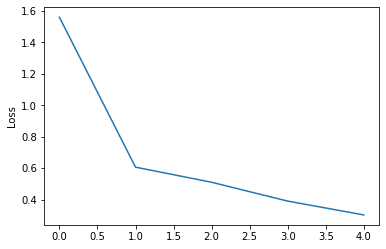

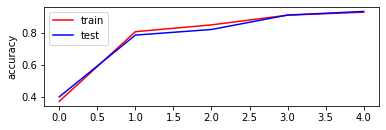

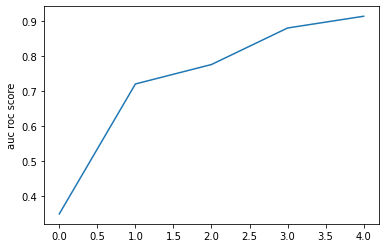

In [6]:
plt.plot(lossplot) #lets plot the second line
plt.ylabel('Loss')
plt.show()

plt.subplot(2,1,1)
plt.plot(accuracytrainplot,'r',label="train")
plt.plot(accuracytestplot,'b',label="test")
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(aucrocplot) #lets plot the second line
plt.ylabel('auc roc score')
plt.show()

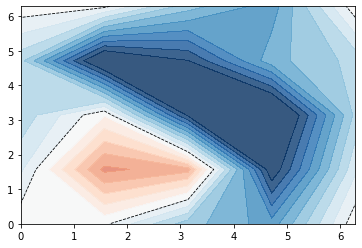

In [7]:
predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
predictions_grid = (predictions_grid + 1.0) / 2.0
predictions_grid = pd.DataFrame.from_dict(predictions_grid)
predictions_grid = predictions_grid.iloc[:, :]
predictions_grid = predictions_grid[0].apply(lambda x: 0 if x <= 0.5 else 1)
predictions_grid = predictions_grid.to_numpy()
Z=predictions_grid
Z=np.reshape(zminus, xx.shape)
Z
cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))

#plt.colorbar(cnt, ticks=[-1, 0, 1])

In [8]:
# METRICS FOR TESTING DATA
expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
prob_class_one = pd.DataFrame.from_dict(prob_class_one)
prob_class_one = prob_class_one.iloc[:, :]
prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
prob_class_one = prob_class_one.to_numpy()
print(metrics.accuracy_score(y_test, prob_class_one))
print(metrics.confusion_matrix(y_test, prob_class_one))

0.94
[[110  16]
 [  8 266]]


<Figure size 1440x1440 with 0 Axes>

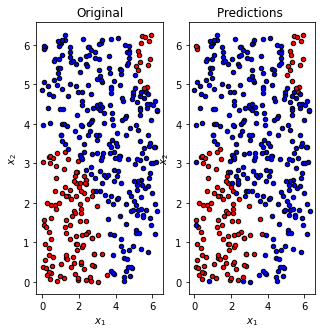

In [9]:
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
y_pred = (prob_class_one >= 0.5)


y_test1 = pd.DataFrame.from_dict(y_test)
y_test1 = y_test1.iloc[:, :]
y_test1 =  y_test1[0].apply(lambda x: 0 if x <= 0 else 1)
y_test1 = y_test1.to_numpy()

fig= plt.figure(figsize=(20,20))
fig , axes = plt.subplots(1, 2, figsize=(5, 5))
plot_data(X_test, y_test1, fig, axes[0])
plot_data(X_test, y_pred, fig, axes[1])
#plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Original")
axes[1].set_title("Predictions ")
plt.show()

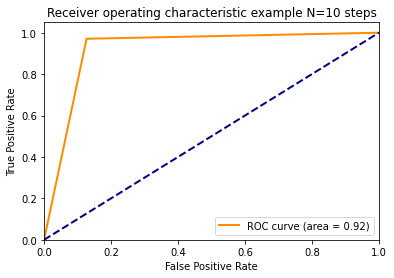

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()

expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
y_pred = (prob_class_one >= 0.5)

y_test=y_test
y_score=y_pred

for i in range(len(y_test)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example Ν=10 steps')
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

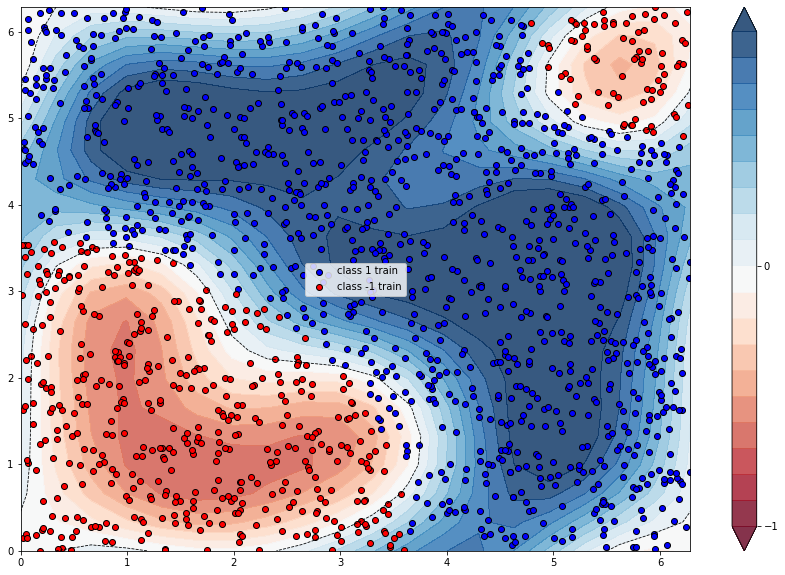

In [11]:
plt.figure()
cm = plt.cm.RdBu
fig= plt.figure(figsize=(15,10))
# make data for decision regions
xx, yy = np.meshgrid(np.linspace(scalinga, scalingb, 20), np.linspace(scalinga,scalingb, 20))
X_grid = [np.array([x,y]) for x, y in zip(xx.flatten(), yy.flatten())]
predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
zminus = (predictions_grid + 1.0) / 2.0
zminus = predictions_grid
Z=np.reshape(zminus, xx.shape)
# plot decision regions
cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1., 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])


# plot data
plt.scatter(
    X_train[:, 0][e_train == 1],
    X_train[:, 1][e_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_train[:, 0][e_train == -1],
    X_train[:, 1][e_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

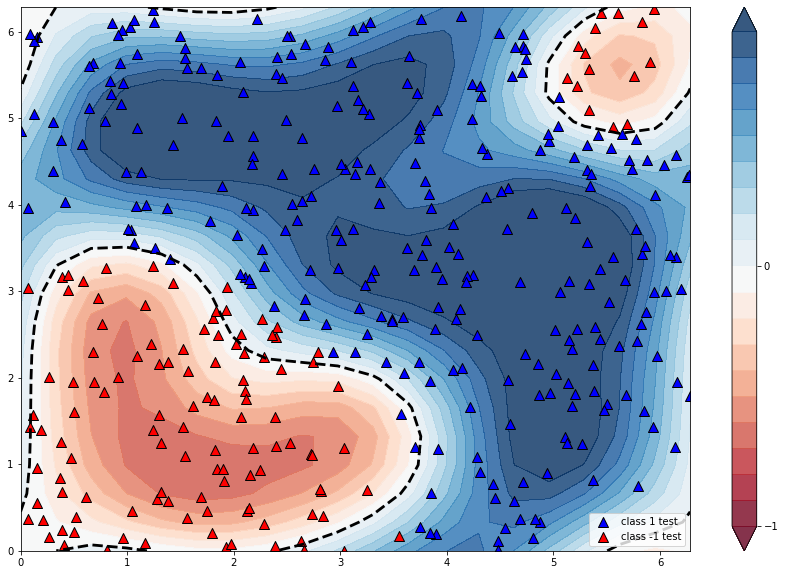

In [12]:
# convert expectations to classes
expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
#y_pred = (prob_class_one >= 0.5)


plt.figure()
cm = plt.cm.RdBu
fig= plt.figure(figsize=(15,10))
# make data for decision regions
xx, yy = np.meshgrid(np.linspace(scalinga, scalingb, 20), np.linspace(scalinga,scalingb, 20))
X_grid = [np.array([x,y]) for x, y in zip(xx.flatten(), yy.flatten())]


#predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
#zminus = (predictions_grid + 1.0) / 2.0
#zminus = predictions_grid
#Z=np.reshape(zminus, xx.shape)

predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
predictions_grid = (predictions_grid + 1.0) / 2.0
predictions_grid = pd.DataFrame.from_dict(predictions_grid)
predictions_grid = predictions_grid.iloc[:, :]
predictions_grid = predictions_grid[0].apply(lambda x: 0 if x <= 0.5 else 1)
predictions_grid = predictions_grid.to_numpy()
Z=predictions_grid
Z=np.reshape(zminus, xx.shape)




# plot decision regions
cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1., 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(2.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])


# plot data
plt.scatter(
    X_test[:, 0][y_test == 1],
    X_test[:, 1][y_test == 1],
    c="b",s=100,
    marker="^",
    edgecolors="k",
    label="class 1 test",
)
plt.scatter(
    X_test[:, 0][y_test == -1],
    X_test[:, 1][y_test == -1],
    c="r",s=100,
    marker="^",
    edgecolors="k",
    label="class -1 test",
)



plt.legend()
plt.show()


<Figure size 432x288 with 0 Axes>

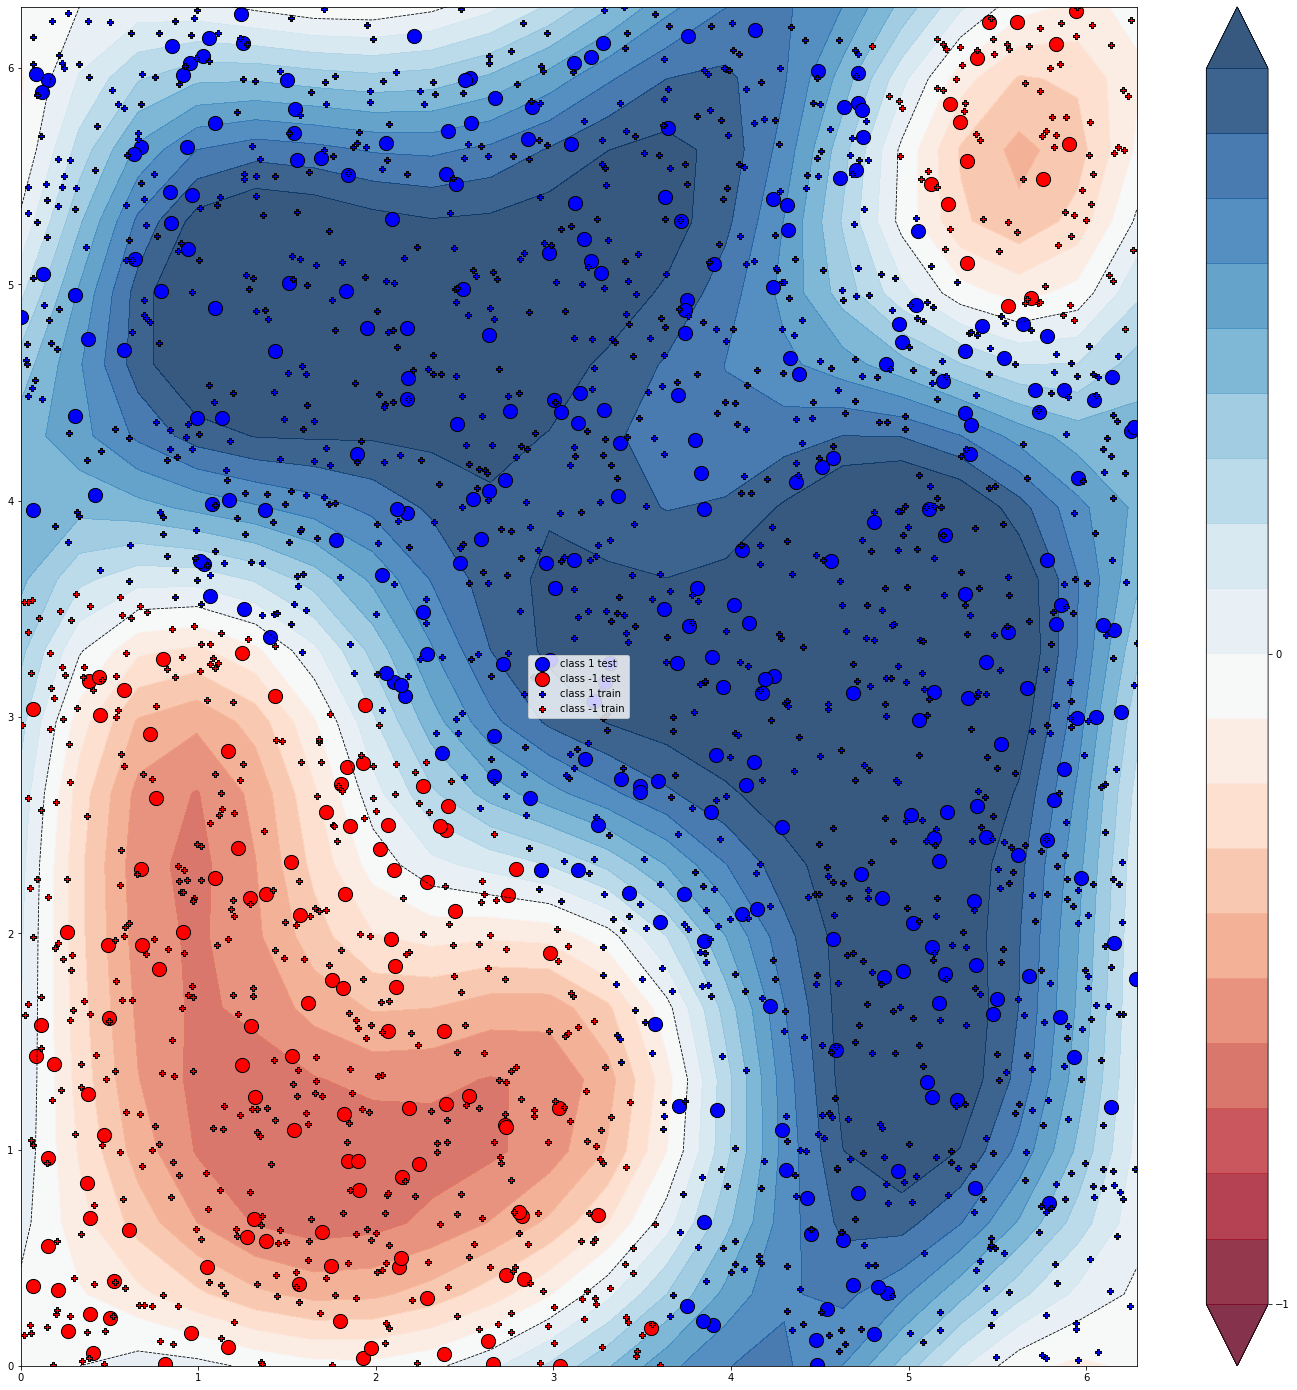

In [13]:
plt.figure()
cm = plt.cm.RdBu
fig= plt.figure(figsize=(25,25))

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(scalinga, scalingb, 20), np.linspace(scalinga,scalingb, 20))
X_grid = [np.array([x,y]) for x, y in zip(xx.flatten(), yy.flatten())]


predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
zminus = (predictions_grid + 1.0) / 2.0
zminus = predictions_grid
Z=np.reshape(zminus, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1., 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])





# plot data
plt.scatter(
    X_test[:, 0][y_test == 1],
    X_test[:, 1][y_test == 1],
    c="b",s=200,
    marker="o",
    edgecolors="k",
    label="class 1 test",
)
plt.scatter(
    X_test[:, 0][y_test == -1],
    X_test[:, 1][y_test == -1],
    c="r",s=200,
    marker="o",
    edgecolors="k",
    label="class -1 test",
)

# plot data
plt.scatter(
    X_train[:, 0][e_train == 1],
    X_train[:, 1][e_train == 1],
    c="b",
    marker="P",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_train[:, 0][e_train == -1],
    X_train[:, 1][e_train == -1],
    c="r",
    marker="P",
    edgecolors="k",
    label="class -1 train",
)


plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

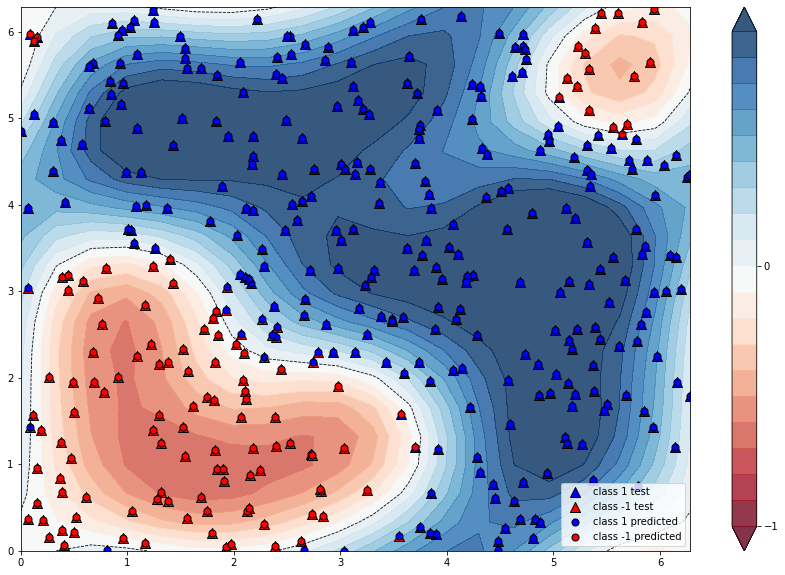

In [14]:

# convert expectations to classes
expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
#y_pred = (prob_class_one >= 0.5)


plt.figure()
cm = plt.cm.RdBu
fig= plt.figure(figsize=(15,10))
# make data for decision regions
xx, yy = np.meshgrid(np.linspace(scalinga,scalingb, 20), np.linspace(scalinga,scalingb, 20))
X_grid = [np.array([x,y]) for x, y in zip(xx.flatten(), yy.flatten())]


#predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
#zminus = (predictions_grid + 1.0) / 2.0
#zminus = predictions_grid
#Z=np.reshape(zminus, xx.shape)

predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
predictions_grid = (predictions_grid + 1.0) / 2.0
predictions_grid = pd.DataFrame.from_dict(predictions_grid)
predictions_grid = predictions_grid.iloc[:, :]
predictions_grid = predictions_grid[0].apply(lambda x: 0 if x <= 0.5 else 1)
predictions_grid = predictions_grid.to_numpy()
Z=predictions_grid
Z=np.reshape(zminus, xx.shape)




# plot decision regions
cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1., 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])


# plot data
plt.scatter(
    X_test[:, 0][y_test == 1],
    X_test[:, 1][y_test == 1],
    c="b",s=100,
    marker="^",
    edgecolors="k",
    label="class 1 test",
)
plt.scatter(
    X_test[:, 0][y_test == -1],
    X_test[:, 1][y_test == -1],
    c="r",s=100,
    marker="^",
    edgecolors="k",
    label="class -1 test",
)

# plot data
plt.scatter(
    X_test[:, 0][prob_class_one >= 0.5],
    X_test[:, 1][prob_class_one >= 0.5],
    c="b",s=50,
    marker="o",
    edgecolors="k",
    label="class 1 predicted",
)
plt.scatter(
    X_test[:, 0][prob_class_one <= 0.5],
    X_test[:, 1][prob_class_one <= 0.5],
    c="r",
    marker="o",s=50,
    edgecolors="k",
    label="class -1 predicted",
)

plt.legend()
plt.show()


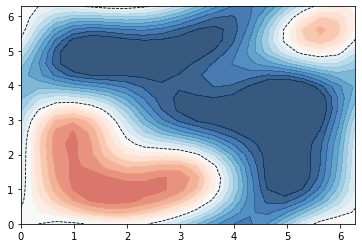

In [15]:
predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
predictions_grid = (predictions_grid + 1.0) / 2.0
predictions_grid = pd.DataFrame.from_dict(predictions_grid)
predictions_grid = predictions_grid.iloc[:, :]
predictions_grid = predictions_grid[0].apply(lambda x: 0 if x <= 0.5 else 1)
predictions_grid = predictions_grid.to_numpy()
Z=predictions_grid
Z=np.reshape(zminus, xx.shape)
Z
cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))

#plt.colorbar(cnt, ticks=[-1, 0, 1])